<a href="https://colab.research.google.com/github/Mastemace/GZAPV_2021/blob/main/P20041/GZAPV_cv_03_03_eye_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import cv2 as cv
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def separation_folder_hough(paths, out_dir):
    for path in paths:
        base_name = path.split('/')[1]
        img  = cv.imread(path)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) 
        circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT, 10, 10, minRadius = 900, maxRadius = 1700)
        circle  = circles[0][0]
        circle[2] *= 1.05
        
        min_x = np.clip(int(circle[0]-circle[2]), 0, img.shape[1]-1)
        max_x = np.clip(int(circle[0]+circle[2]), 0, img.shape[1]-1)
        min_y = np.clip(int(circle[1]-circle[2]), 0, img.shape[0]-1)
        max_y = np.clip(int(circle[1]+circle[2]), 0, img.shape[0]-1)
        
        img = img[min_y:max_y, min_x:max_x, ...]
        cv.imwrite(out_dir+'/'+base_name, img)    
        
        
def resize_folder(paths, out_dir, out_res):
    for path in paths:
        base_name = path.split('/')[1]
        img  = cv.imread(path)
       
        #preskalovani, aby vetsi strana byla rovna out_res
        if img.shape[0]>img.shape[1]:
            dx = int(out_res/img.shape[0] * img.shape[1])
            img = cv.resize(img, (dx, out_res), interpolation = cv.INTER_LANCZOS4)
        else:
            dy = int(out_res/img.shape[1] * img.shape[0])
            img = cv.resize(img, (out_res, dy), interpolation = cv.INTER_LANCZOS4)
            
        #vycentrovani    
        sy = (out_res-img.shape[0])//2
        sx = (out_res-img.shape[1])//2

        #vlozeni do ctvercoveho obrazku
        out_img = np.zeros((out_res, out_res, 3))
        out_img[sy:img.shape[0]+sy, sx:img.shape[1]+sx, ...] = img
        
        cv.imwrite(out_dir+'/'+base_name, out_img)

def equalize(paths, out_dir): 
    for path in paths:
        base_name = path.split('/')[1]
        img = cv.imread(path)
        
        img = cv.cvtColor(img, cv.COLOR_BGR2LAB)
        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img[...,0] = clahe.apply(img[...,0])
        img = cv.cvtColor(img, cv.COLOR_LAB2BGR)
        
        cv.imwrite(out_dir+'/'+base_name, img)
        
        
def extract(paths, out_dir):
    for path in paths:
        base_name = path.split('/')[1]
        img = cv.imread(path)
        before = img.copy()
        
        out_img = cv.fastNlMeansDenoisingColored(img, 3)
        out_img = cv.medianBlur(out_img, 5)
        
        dx, dy = cv.spatialGradient(cv.cvtColor(out_img, cv.COLOR_BGR2GRAY))
        out_img = np.power(np.power(dx,2.0)+np.power(dy,2.0), 0.5)
        
        
        
        out_img = out_img.astype('uint8')
        out_img = cv.medianBlur(out_img, 5)
        out_img = cv.medianBlur(out_img, 5)

        _,out_img = cv.threshold(out_img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
        cv.imwrite(out_dir+'/'+base_name, out_img) 
        
        
        out_img = cv.morphologyEx(out_img, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3)))
        out_img = cv.morphologyEx(out_img, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE, (9,9)))
        out_img = cv.GaussianBlur(out_img, (3,3), 1)//255
        out_img = before*np.expand_dims(out_img, -1)
        cv.imwrite(out_dir+'/'+base_name, out_img)

In [14]:
#separation_folder_hough(sorted(glob('sample/*.*')), 'sample_hough')
#resize_folder(sorted(glob('sample_hough/*.*')), 'sample_hough_resized', 1024)
#equalize(sorted(glob('sample_hough_resized/*.*')), 'equalized')
extract(sorted(glob('sample_equalized/*.*')), 'sample_extracted')

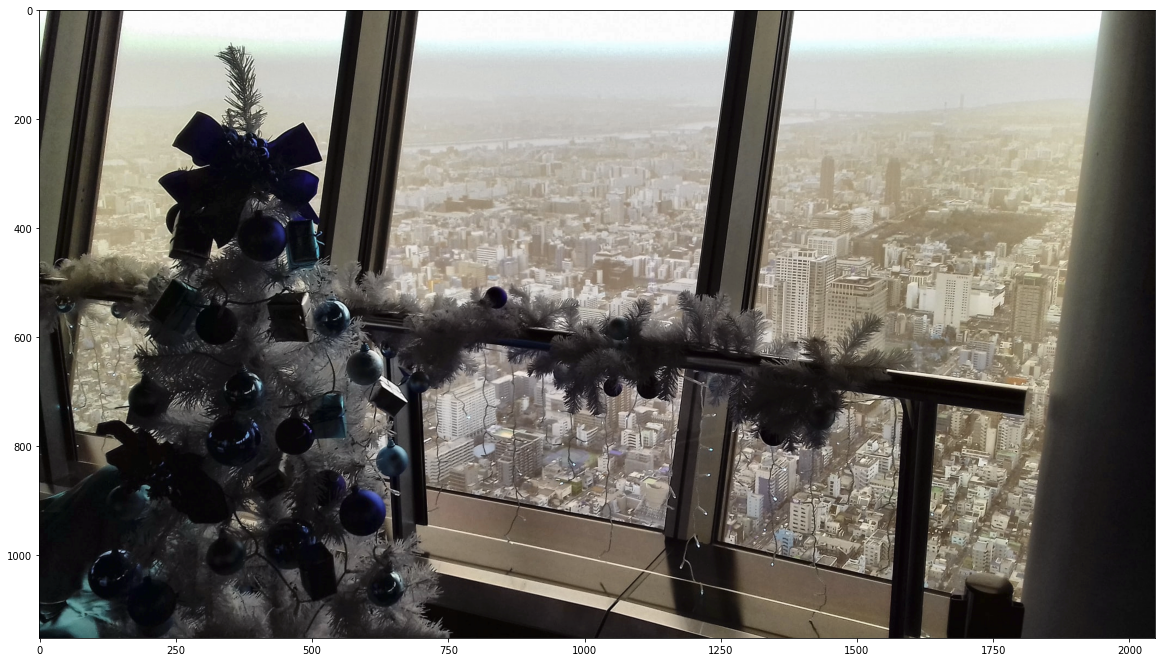

In [24]:
img = cv.imread('test_clahe.jpg')

img = cv.cvtColor(img, cv.COLOR_BGR2LAB)
clahe = cv.createCLAHE(clipLimit = 1.0, tileGridSize = (8,8))
img[...,0] = clahe.apply(img[...,0])
img = cv.cvtColor(img, cv.COLOR_LAB2BGR)
cv.imwrite('test_clahe_finished.jpg', img)

plt.figure(figsize=(20,20))
plt.imshow(img)